# Analysis of natural language in Github issues

### Language identification

We analyze a 2,000 subset of bigcode data.

In [2]:
from datasets import load_dataset

ds = load_dataset("bigcode/subset-github-issues", split="train", use_auth_token=True)

In [3]:
ds[0]

{'repo': 'justarrived/justarrived.github.io',
 'org': 'justarrived',
 'issue_id': 183724936,
 'issue_number': 80,
 'pull_request': None,
 'events': [{'action': 'opened',
   'author': 'tikkat',
   'comment': None,
   'comment_id': None,
   'datetime': 1476805329000,
   'description': '',
   'title': 'Mobile header with hamburger menu dropdown',
   'type': 'issue'},
  {'action': 'closed',
   'author': 'tikkat',
   'comment': None,
   'comment_id': None,
   'datetime': 1476994993000,
   'description': None,
   'title': None,
   'type': 'issue'}]}

In [4]:
# remove columns that are not needed
ds = ds.remove_columns(['repo', 'org', 'issue_id', 'issue_number', 'pull_request'])

In [5]:
ds

Dataset({
    features: ['events'],
    num_rows: 10000
})

In [6]:
#for description and title extract inside events, create a new column called text and concatenate title and description if they are both not None
#ds = ds.map(lambda x: {'text': [e['title'] + e['description'] + e['comment'] for e in x['events'] if e['title'] is not None and e['description'] is not None]})
ds = ds.map(lambda x: {'text': str(x['title']) + str(x['description']) + str(x['comment']) for x in x['events']})
#remove the word None from the text column
ds = ds.map(lambda x: {'text': x['text'].replace('None', '')})
#remove empty rows from the dataset
ds = ds.filter(lambda x: len(x['text']) > 0)

In [7]:
ds[0]

{'events': [{'action': 'opened',
   'author': 'd4mation',
   'comment': None,
   'comment_id': None,
   'datetime': 1472089995000,
   'description': "The Public Version would fall short of other services like http://pokedextracker.com if it has no way to share the completion progress with another Users.\r\n\r\nGET parameters may be a way to get around this, provided it doesn't get too long.\r\n\r\nIt would be static, but better than nothing. Unfortunately that's the downside to not having a central database ¯\\\\\\_(ツ)\\_/¯\r\n\r\nBuilding on #3",
   'title': 'Ability to Share Views for Public Version',
   'type': 'issue'}],
 'text': "Ability to Share Views for Public VersionThe Public Version would fall short of other services like http://pokedextracker.com if it has no way to share the completion progress with another Users.\r\n\r\nGET parameters may be a way to get around this, provided it doesn't get too long.\r\n\r\nIt would be static, but better than nothing. Unfortunately that's

In [8]:
ds = ds.remove_columns(['events'])

In [9]:
ds[0]['text']

"Ability to Share Views for Public VersionThe Public Version would fall short of other services like http://pokedextracker.com if it has no way to share the completion progress with another Users.\r\n\r\nGET parameters may be a way to get around this, provided it doesn't get too long.\r\n\r\nIt would be static, but better than nothing. Unfortunately that's the downside to not having a central database ¯\\\\\\_(ツ)\\_/¯\r\n\r\nBuilding on #3"

In [10]:
from language_identifier import extract_nl_text, FunctionDatasetModifyingDocuments

In [11]:
ds

Dataset({
    features: ['text'],
    num_rows: 7136
})

In [12]:
dataset = ds
# extraction of NL
dataset = dataset.map(extract_nl_text)

  0%|          | 0/7136 [00:00<?, ?ex/s]

Two new columns in the dataset: nl_text with a string where the extracted dosctrings and comments are concatenated, nl_size: size of nl_text

In [13]:
dataset

Dataset({
    features: ['text', 'nl_text', 'nl_size'],
    num_rows: 7136
})

Text(0.5, 1.0, 'distribution of the size of issues titles+description+comments (on a 7k none empty subset)')

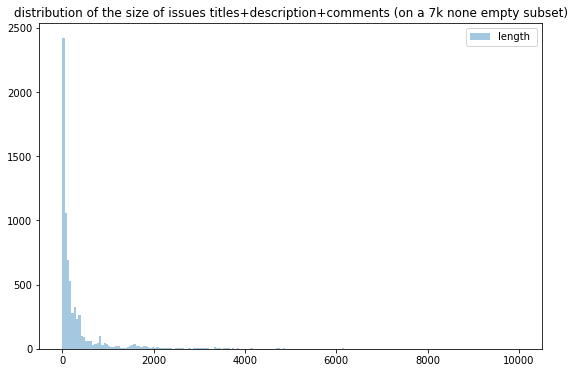

In [14]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(dataset['nl_size'], bins=np.linspace(0, 10_000, 200), alpha=0.4, label="length ")
plt.legend(prop ={'size': 10})
#truncated distribution
plt.title("distribution of the size of issues titles+description+comments (on a 7k none empty subset)")

Now let's identify languages

In [15]:
path_fasttext_model = "fasttext_model/lid.176.bin"
func_dataset_modifying_documents = FunctionDatasetModifyingDocuments(
    path_fasttext_model
)

In [16]:
dataset[0]["nl_text"]

"Ability to Share Views for Public VersionThe Public Version would fall short of other services like http://pokedextracker.com if it has no way to share the completion progress with another Users.\r\n\r\nGET parameters may be a way to get around this, provided it doesn't get too long.\r\n\r\nIt would be static, but better than nothing. Unfortunately that's the downside to not having a central database ¯\\\\\\_(ツ)\\_/¯\r\n\r\nBuilding on #3"

In [17]:
output = func_dataset_modifying_documents(dataset[0])

In [18]:
output.keys()

dict_keys(['text', 'nl_text', 'nl_size', 'nl_language', 'nl_language_score'])

In [19]:
print(f"detected language id is: {output['nl_language']}")
print(f"Model prediction score of the language: {output['nl_language_score']}")

detected language id is: en
Model prediction score of the language: 0.9506450295448303


In [20]:
print(dataset[4]["nl_text"])

Closing as I was mistaken in thinking it was a conflict with this particular package. 

This is related to issue [#196](https://github.com/smashwilson/merge-conflicts/issues/196)


In [21]:
output2 = func_dataset_modifying_documents(dataset[4])
print(f"detected language id is: {output2['nl_language']}")
# zh stands for Chinese
print(f"Model prediction score of the language: {output2['nl_language_score']}")

detected language id is: en
Model prediction score of the language: 0.9665908813476562


In [22]:
dataset[0]["nl_text"]

"Ability to Share Views for Public VersionThe Public Version would fall short of other services like http://pokedextracker.com if it has no way to share the completion progress with another Users.\r\n\r\nGET parameters may be a way to get around this, provided it doesn't get too long.\r\n\r\nIt would be static, but better than nothing. Unfortunately that's the downside to not having a central database ¯\\\\\\_(ツ)\\_/¯\r\n\r\nBuilding on #3"

Now let's run language detection on the full 2,000 samples subset

In [23]:
# Could be improved by allowing multiprocessing with map (currently doesn't work)
dataset_language = dataset.map(
    func_dataset_modifying_documents, num_proc=1
)  # num_proc=cpu_count()
print("Fasttext done")

  0%|          | 0/7136 [00:00<?, ?ex/s]

Fasttext done


In [24]:
dataset_language

Dataset({
    features: ['text', 'nl_text', 'nl_size', 'nl_language', 'nl_language_score'],
    num_rows: 7136
})

In [25]:
ratio = sum([1 if dataset_language["nl_language"][i] != "en" else 0 for i in range(len(dataset))])/len(dataset)
print(f"percentage of non english detected languages {ratio*100}%")

percentage of non english detected languages 6.670403587443946%


In [26]:
#languages that are'n english in the first 200 samples = 8%
L = []
for i in range(200):
    if dataset_language["nl_language"][i] != "en":
        L.append(i)
        print(i)

2
23
62
68
79
89
113
132
134
139


### successful detections

In [27]:
print(dataset_language["nl_language"][23])
print(dataset_language["nl_language_score"][23])
print(dataset_language["nl_text"][23])

ko
0.39888086915016174
LGTM


In [28]:
print(dataset_language["nl_language"][52])
print(dataset_language["nl_language_score"][52])
print(dataset_language["nl_text"][52])

en
0.9581831097602844
Okay, I assumed it was of importance to keep it in the object definition and not use dot notation.


In [29]:
print(dataset_language["nl_language"][75])
print(dataset_language["nl_language_score"][75])
print(dataset_language["nl_text"][75])

en
0.8317049145698547
**Hello! The name of the branch with this Pull Request is not of the `add-USERNAME` pattern so I'm skipping reviewing it for the Git-it challenges.**
If you are completing the Git-it challenges, you'll need to close this Pull Request, rename your branch, push it to your fork of Patchwork on GitHub and then start a new Pull Request. Here's how to rename a branch and push it to GitHub from terminal:
```bash
$ git branch -m add-USERNAME
$ git push origin add-USERNAME
```


In [30]:
print(dataset_language["nl_language"][77])
print(dataset_language["nl_language_score"][77])
print(dataset_language["nl_text"][77])

en
0.7654864192008972
Abort the mission, fixing! D:


In [31]:
print(dataset_language["nl_language"][138])
print(dataset_language["nl_language_score"][138])
print(dataset_language["nl_text"][138])

en
0.987017810344696
your call, either is fine I think. The commits stand on their own.


In [32]:
print(dataset_language["nl_language"][143])
print(dataset_language["nl_language_score"][143])
print(dataset_language["nl_text"][143])

en
0.7688024640083313
0.5.3 is now available.


### failures:

In [33]:
print(dataset_language["nl_language"][79])
print(dataset_language["nl_language_score"][79])
print(dataset_language["nl_text"][79])
print("\n")
print(dataset_language["nl_language"][11])
print(dataset_language["nl_language_score"][11])
print(dataset_language["nl_text"][11])
print("\n")
print(dataset_language["nl_language"][110])
print(dataset_language["nl_language_score"][110])
print(dataset_language["nl_text"][110])
print("\n")
print(dataset_language["nl_language"][139])
print(dataset_language["nl_language_score"][139])
print(dataset_language["nl_text"][139])

ko
0.39888086915016174
LGTM


en
0.8737061023712158
Congratulations @tieguy @mattbk! We've landed this PR! 💃 

It's now merged into an integration branch under #4221, whence it will go into master and out into production.

Great work! 👏  😄

!m @tieguy @mattbk 


en
0.9804384112358093
Okay thanks anyway!


de
0.353746235370636
👍 


Text(0.5, 1.0, 'distribution of the size of issues titles+description+comments (on a 7k none empty subset)')

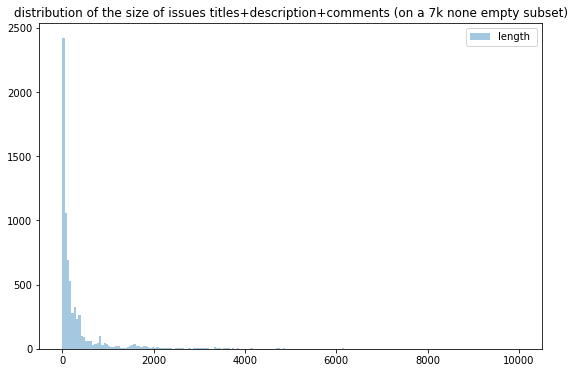

In [34]:
#distribution of langauges

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(dataset['nl_size'], bins=np.linspace(0, 10_000, 200), alpha=0.4, label="length ")
plt.legend(prop ={'size': 10})
#truncated distribution
plt.title("distribution of the size of issues titles+description+comments (on a 7k none empty subset)")

In [35]:
type(dataset_language["nl_language"])

list

Text(0.5, 1.0, 'NL language distribution in train split of bigcode dataset GitHub Issues (7k None empty Set subset)')

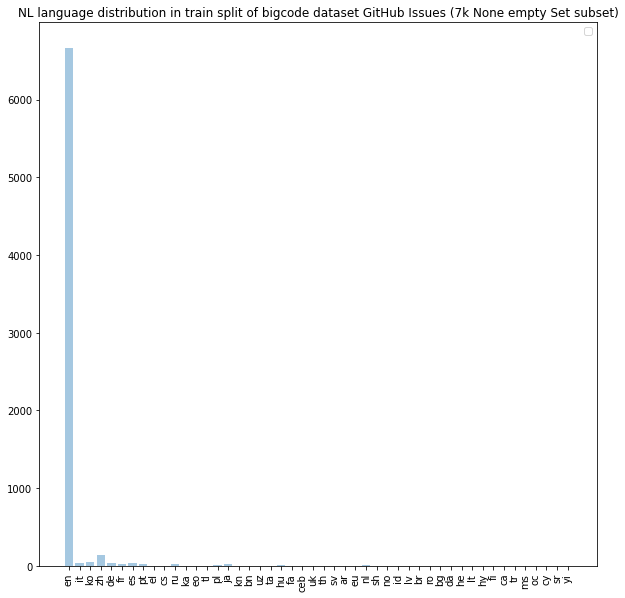

In [66]:
import pandas
from collections import Counter
letter_counts = Counter(dataset_language["nl_language"])
plt.figure(figsize=(10,10))
plt.legend(prop ={'size': 10})
plt.bar(letter_counts.keys(), letter_counts.values(), alpha=0.4, label="count")
plt.xticks(rotation=90)
plt.title("NL language distribution in train split of bigcode dataset GitHub Issues (7k None empty Set subset)")